In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_extraction import DictVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer
from sklearn.metrics import brier_score_loss

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import json

import Feature_Extraction as fe

In [2]:
# load the dataset

data = open('data/tousend_cons_rels.CSV', encoding="ANSI").read()
label, r1, r2, rmix = [], [], [], []
size = 500
for i, line in enumerate(data.split("\n")):
    if i >= size:
        break
    if line != '' and line.isspace() != True:
        content = line.split(';')
        label.append(content[0])
        r1.append(content[1])
        r2.append(content[2])
        rmix.append(content[1]+content[2])
        
index = 0
size = len(label)
x = []
while index < size:
    x.append(fe.createFBag(r1[index], r2[index]))
    index = index + 1
    
vec = DictVectorizer()

xx = vec.fit_transform(x).toarray()

yy = []
for l in label:
    if l == 'true':
        yy.append(1)
    else:
        yy.append(-1)

In [75]:
yy2 = []
for val in yy:
    if val == 1:
        yy2.append(1)
    else:
        yy2.append(0)

In [ ]:
#0.65 (+/-0.40) for {'C': 0.23357214690901212, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}
LR_clf =  LogisticRegression(C=4.281332398719396, class_weight='balanced', penalty= 'l1', solver= 'liblinear')
#ComplementNM is an implementation of MultinomialNB
NB_clf = ComplementNB()
#min_samples_leaf = 1 --> the most important parameter, min_samples_split = 2 or 5 --> second most important
#0.64 (+/-0.39) for {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
ET_clf = ExtraTreesClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10)


In [98]:
import warnings
warnings.filterwarnings('ignore')


kfold = 5
cv = RepeatedStratifiedKFold(n_splits=kfold, n_repeats=10)

#train_sizes = [50, 100, 150, 200, 250, 300, 350, 400,  450, 500]
train_sizes = range(10, 500, 10)

#scoring =  {'brier_score_loss': make_scorer(brier_score_loss, pos_label=1)}
scoring =  {'brier_score_loss': make_scorer(brier_score_loss, pos_label=1)}
score_keys = ['test_brier_score_loss', 'train_brier_score_loss']
LR_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}
NB_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}
ET_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}

for size in train_sizes:
    
    LR_clf =  LogisticRegression(C=4.281332398719396, class_weight='balanced', penalty= 'l1', solver= 'liblinear')
    NB_clf = ComplementNB()
    ET_clf = ExtraTreesClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10)
    clfs = [LR_clf, NB_clf, ET_clf]
    
    for clf in clfs:
        res = cross_validate(clf, X=xx[:size], y=yy2[:size], cv=cv, scoring=scoring, return_train_score=True)
        
        for key in score_keys:
            if clf == LR_clf:
                LR_scores[key].append(np.absolute(np.mean(res[key])))
            elif clf == NB_clf:
                NB_scores[key].append(np.absolute(np.mean(res[key])))
            else:
                ET_scores[key].append(np.absolute(np.mean(res[key])))
                    

In [99]:
LR_df = pd.DataFrame(LR_scores)
NB_df = pd.DataFrame(NB_scores)
ET_df = pd.DataFrame(ET_scores)

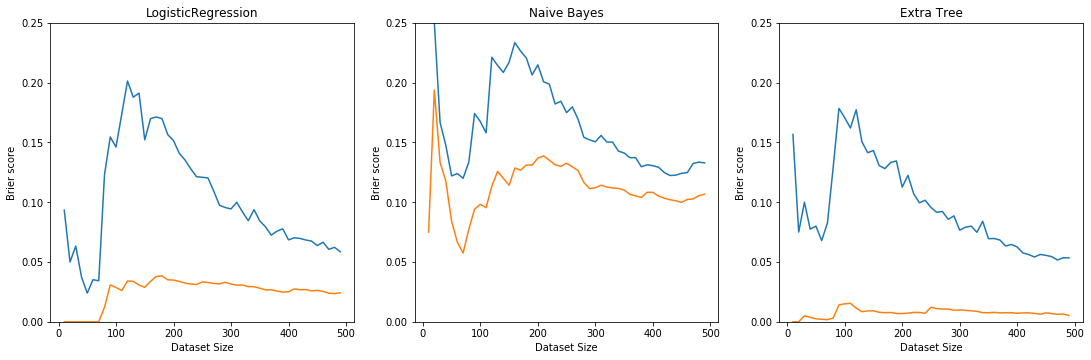

In [100]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5.5)

lrp = sns.lineplot(train_sizes, LR_df['test_brier_score_loss'], ax=ax1)
lrp = sns.lineplot(train_sizes, LR_df['train_brier_score_loss'], ax=ax1)
lrp.set(xlabel='Dataset Size', ylabel='Brier score')
lrp.set_title('LogisticRegression')
lrp.set_ylim(ymin=0, ymax=0.25)

nbp = sns.lineplot(train_sizes, NB_df['test_brier_score_loss'], ax=ax2)
nbp = sns.lineplot(train_sizes, NB_df['train_brier_score_loss'], ax=ax2)
nbp.set(xlabel='Dataset Size', ylabel='Brier score')
nbp.set_title('Naive Bayes')
nbp.set_ylim(ymin=0, ymax=0.25)

etp = sns.lineplot(train_sizes, ET_df['test_brier_score_loss'], ax=ax3)
etp = sns.lineplot(train_sizes, ET_df['train_brier_score_loss'], ax=ax3)
etp.set(xlabel='Dataset Size', ylabel='Brier score')
etp.set_title('Extra Tree')
etp.set_ylim(ymin=0, ymax=0.25)

plt.savefig('learning_cureves.pdf', bbox_inches = "tight")